In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

from cda_prep import *
from cda_util import *
from cda_models import *

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cyber Data Analytics - Lab 1
Cheatsheet: https://gist.github.com/agalea91/545e2337b94d965be788f7db18b1f497

**Data description**
 - `issuercountrycode`: country where the card was issued
 - `txvariantcode`: the card type that was used (subbrand of visa or master card)
 - `bin`: card issuer identifier
 - `amount`/currencycode: transaction amount in minor units (so 100 EUR = 100 euro cent)
 - `shoppercountrycode`: IP address country
 - `shopperinteraction`: Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription
 - `simple_journal`: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”
 - `bookingdate`: only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.
 - `cardverificationresponsesupplied`: did the shopper provide his 3 digit CVC/CVV2 code?
 - `cvcresponsecode`: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
 - `creationdate`: Date of transaction
 - `accountcode`: merchant’s webshop
 - `mail_id`: Email address
 - `ip_id`: Ip address
 - `card_id`: Card number

**Variables to handle carefully:**

`simple_journal` /
`bookingdate` /
`creationdate`

### 1. Get data

In [247]:
df, df_raw = get_data('data/data_for_student_case.csv')

In [248]:
print("Raw dataset:")
display(df_raw.head(3))

print("Processed dataset:")
display(df.head(3))

Raw dataset:


,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,labels
txid,,,,,,,,,,,,,,,,
1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,1.0
2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1.0
3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,1.0


Processed dataset:


,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,labels,amount_dollar
txid,,,,,,,,,,,,,,,,,
1,2015-11-09 14:26:51,76,2,530056,64800.0,2,98,1,1,0,2015-07-01 23:03:11,1,187702,7386,73358,1.0,4122.137405
2,2015-11-09 14:27:38,76,2,547046,44900.0,2,98,1,1,0,2015-07-02 04:50:55,1,834,194109,44739,1.0,2837.824840
3,2015-11-23 16:34:16,76,2,528843,149900.0,2,98,1,1,0,2015-07-02 14:30:28,1,119287,189655,122802,1.0,9474.163554


### 2. Explore

In [4]:
df_stats = get_class_balance(df)

with pd.option_context('display.float_format', lambda x: "%.3f" % x):
    display(df_stats)

,count,pct
,,
Legitimate,236691,99.854
Fraud,345,0.146
Total,237036,100.000


### 3. SMOTE Analysis

In [249]:
# Split data and labels
X, y = split_labels(df)

# Drop columns
X.drop(columns=['amount_dollar', 'bookingdate', 'creationdate'], inplace=True)

In [251]:
clf_smote_test = [
    (KNeighborsClassifier(5), 5),
    (LogisticRegression(solver='lbfgs'), ""),
    (RandomForestClassifier(n_estimators=100), 100)
]

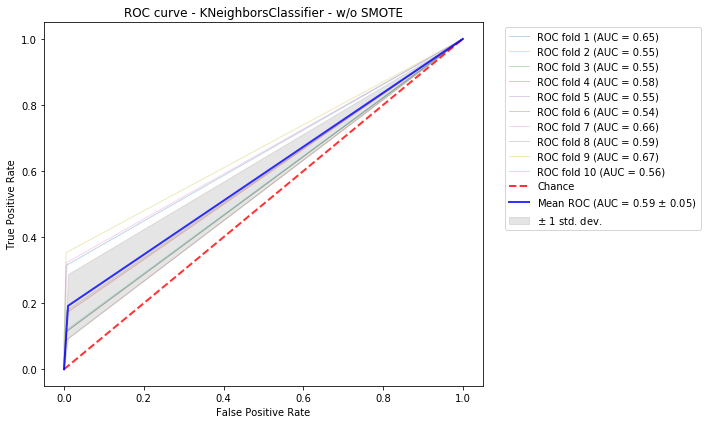

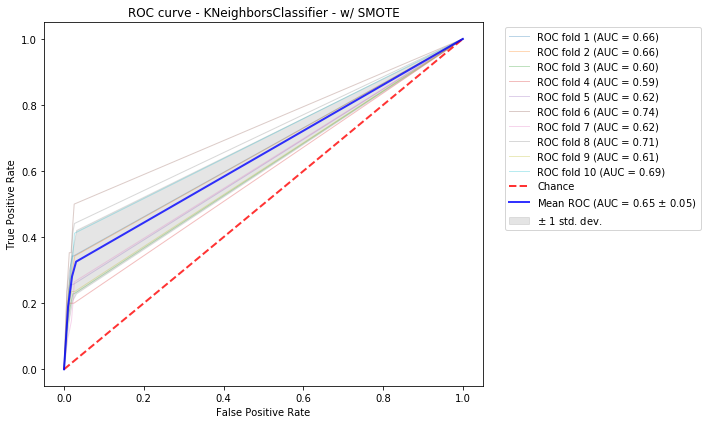

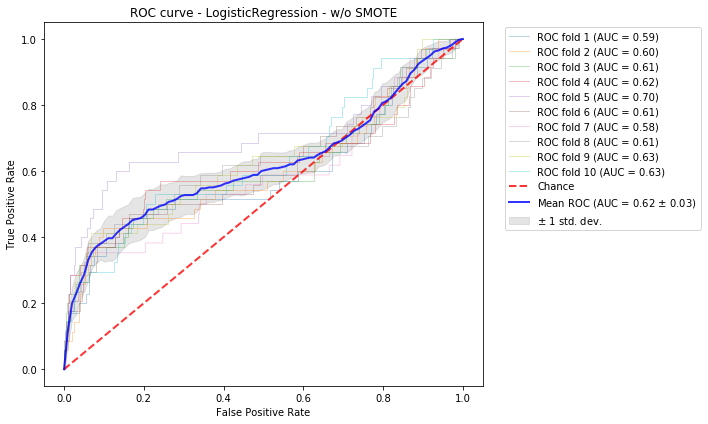

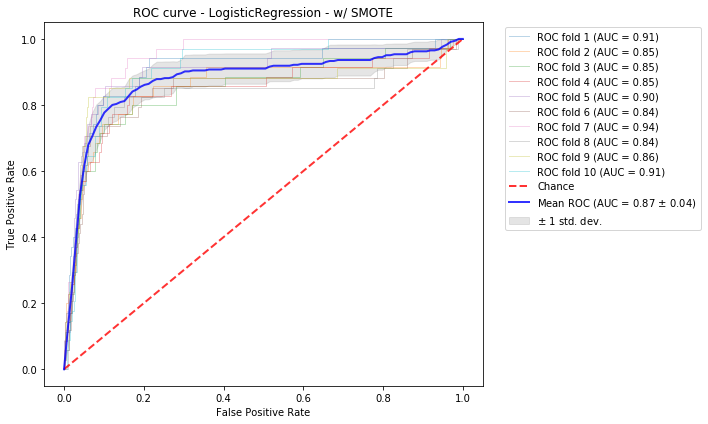

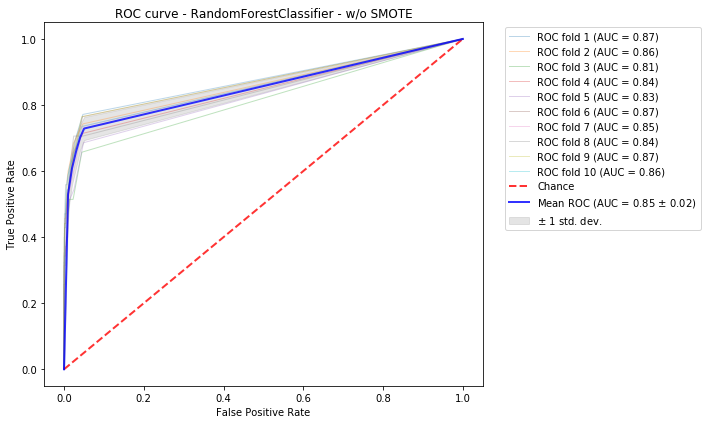

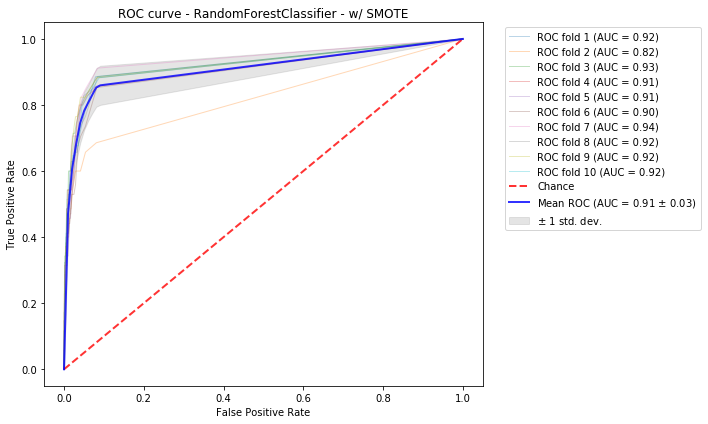

In [252]:
results = pd.DataFrame(columns=['Classifier', 'Param', 'SMOTE?', 'Mean AUC', 'Std AUC', 'Precision', 'Recall', 'F1-score', 'Confmat'])

i = 0
for (clf, param) in clf_smote_test:
    
    # NoSmote
    confmat, precision, recall, f1, mean_auc, std_auc = roc_cross_val(X, y, clf, prepare_null, 10, "w/o SMOTE")
    results.loc[i] = [type(clf).__name__, param, False, mean_auc, std_auc, precision, recall, f1, confmat]
    
    i+=1
    
    # Smote
    confmat, precision, recall, f1, mean_auc, std_auc = roc_cross_val(X, y, clf, prepare_smote_analysis, 10, "w/ SMOTE")
    results.loc[i] = [type(clf).__name__, param, True, mean_auc, std_auc, precision, recall, f1, confmat]
    
    i+=1
    

In [254]:
results

,Classifier,Param,SMOTE?,Mean AUC,Std AUC,Precision,Recall,F1-score,Confmat
0,KNeighborsClassifier,5,False,0.590981,0.048322,0.333333,0.011594,0.022409,IsFraud IsLegit Total PredFraud ...
1,KNeighborsClassifier,5,True,0.649213,0.048252,0.020853,0.257971,0.038587,IsFraud IsLegit Total PredFraud ...
2,LogisticRegression,,False,0.617825,0.032168,0.000000,0.000000,0.000000,IsFraud IsLegit Total PredFraud ...
3,LogisticRegression,,True,0.874963,0.035739,0.008179,0.805797,0.016194,IsFraud IsLegit Total PredFraud ...
4,RandomForestClassifier,100,False,0.849674,0.018406,0.888889,0.092754,0.167979,IsFraud IsLegit Total PredFraud ...
5,RandomForestClassifier,100,True,0.907921,0.030850,0.202128,0.165217,0.181818,IsFraud IsLegit Total PredFraud ...


In [255]:
results.apply(lambda x : display(x['Confmat']), axis=1)

,IsFraud,IsLegit,Total
PredFraud,4,341,345
PredLegit,8,236683,236691
Total,12,237024,237036


,IsFraud,IsLegit,Total
PredFraud,89,256,345
PredLegit,4179,232512,236691
Total,4268,232768,237036


,IsFraud,IsLegit,Total
PredFraud,0,345,345
PredLegit,11,236680,236691
Total,11,237025,237036


,IsFraud,IsLegit,Total
PredFraud,278,67,345
PredLegit,33711,202980,236691
Total,33989,203047,237036


,IsFraud,IsLegit,Total
PredFraud,32,313,345
PredLegit,4,236687,236691
Total,36,237000,237036


,IsFraud,IsLegit,Total
PredFraud,57,288,345
PredLegit,225,236466,236691
Total,282,236754,237036


0    None
1    None
2    None
3    None
4    None
5    None
dtype: object

In [ ]:

# ## NO SMOTE

# confmat, precision, recall, f1, mean_auc, std_auc = roc_cross_val(X, y, KNeighborsClassifier(2), prepare_null, 10, "w/o SMOTE")

# print("AUC:       {:.3f} ± {:.3f}".format(mean_auc, std_auc))
# print("Precision: {:.3f}".format(precision))
# print("Recall:    {:.3f}".format(recall))
# print("F1 score:  {:.3f}".format(f1))

# display(confmat)


# ## WITH SMOTE

# confmat, precision, recall, f1, mean_auc, std_auc = roc_cross_val(X, y, KNeighborsClassifier(2), prepare_smote_analysis, 10, "w/ SMOTE")

# print("AUC:       {:.3f} ± {:.3f}".format(mean_auc, std_auc))
# print("Precision: {:.3f}".format(precision))
# print("Recall:    {:.3f}".format(recall))
# print("F1 score:  {:.3f}".format(f1))

# display(confmat)
